<a href="https://colab.research.google.com/github/nikbizkit/-/blob/master/Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №8

#Задание

Необходимо выполнить машинный перевод тектового корпуса для формирования набора данных. Обучить на сформированном наборе данных модель трасформер.

Выполнить предсказание с помощью обученной модели. Проанализировать метрику BLEU

Отчет должен содержать: титульный лист, задание с вариантом корпуса текста, скриншоты и краткие пояснения по каждому этапу лабораторной работы, результат BLEU.


#Контрольные вопросы
1. Машинный перевод
2. Архитектура трансформер
3. Механизм внимания
4. Архитектура seq2seq
5. Метрика BLEU

# Часть 1. Формирование корпуса для перевода с помощью предобученной модели

## Установка зависимостей

In [4]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.8 MB/s 
     |████████████████████████████████| 6.6 MB 56.6 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.4 MB/s 


## Импорт библиотек

In [5]:
!pip install torchtext==0.11.0
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k

from transformers import MarianTokenizer, MarianMTModel
from typing import List

from tqdm.auto import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 6.1 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:38tcmalloc: large alloc 1147494400 bytes == 0x3a528000 @  0x7f8f5beb5615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does no

## Вывод информации о видеокарте

In [ ]:
!nvidia-smi

Wed Feb 23 16:57:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Загрузка и распаковка файлов датасета Multi30k

In [ ]:
!wget http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz
!tar -xvzf validation.tar.gz
!wget http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/training.tar.gz
!tar -xvzf training.tar.gz
!wget http://www.quest.dcs.shef.ac.uk/wmt17_files_mmt/mmt_task1_test2016.tar.gz
!tar -xvzf mmt_task1_test2016.tar.gz

--2022-02-23 16:57:24--  http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz
Resolving www.quest.dcs.shef.ac.uk (www.quest.dcs.shef.ac.uk)... 143.167.8.76
Connecting to www.quest.dcs.shef.ac.uk (www.quest.dcs.shef.ac.uk)|143.167.8.76|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz [following]
--2022-02-23 16:57:24--  https://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz
Connecting to www.quest.dcs.shef.ac.uk (www.quest.dcs.shef.ac.uk)|143.167.8.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46329 (45K) [application/x-gzip]
Saving to: ‘validation.tar.gz’

validation.tar.gz   100%[===================>]  45.24K   226KB/s    in 0.2s    

2022-02-23 16:57:25 (226 KB/s) - ‘validation.tar.gz’ saved [46329/46329]

val.de
val.en
URL transformed to HTTPS due to an HSTS policy
--2022-02-23 16:57:25--  https://www.quest.dcs.shef.ac.uk/wmt16_files

## Машинный перевод
Как видно, в датасете только английский и немецкие языки
Для расширения числа языков, используем уже обученную модель и переведём английские предложения на целевой язык (по варианту)

Список моделей можно изучить [тут](https://huggingface.co/Helsinki-NLP)


In [ ]:
src = "en"  # исходный язык
trg = "ru"  # целевой язык

model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"

model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
print(f'Модель переводчик с {src} на {trg} загружена!')

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/293M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

Модель переводчик с en на ru загружена!


# Пакетный перевод для каждой части выборки

In [ ]:
def translate_batch(text_batch):
    with torch.no_grad():
        # токенизируем список с предложениями
        batch = tokenizer(text_batch, return_tensors="pt", padding=True)
        # помещаем батч на GPU
        batch = {k:v.to(device) for k,v in batch.items()}
        # переводим
        gen = model.generate(**batch)
        # декодируем из токенов полученные предложения
        return tokenizer.batch_decode(gen, skip_special_tokens=True)

batch_size = 128

for part in ['train', 'val', 'test2016']:
    text_batch = []
    output_corpus = []
    with open('%s.%s'%(part, src), 'r') as f:
        for line in tqdm(f):
            sample_text = line.strip()
            if len(sample_text) == 0: continue
            text_batch.append(sample_text)
            if len(text_batch) > batch_size - 1 :
                output_corpus.extend(translate_batch(text_batch))
                text_batch = []
    if len(text_batch):
        output_corpus.extend(translate_batch(text_batch))
    with open('%s.%s'%(part, trg), 'w') as f:
        f.write('\n'.join(output_corpus))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Упаковка расширенного корпуса по архивам

In [1]:
!tar -czvf training.tar.gz train.*
!tar -czvf validation.tar.gz val.*
!tar -czvf mmt_task1_test2016.tar.gz test2016.*

tar: train.*: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors
tar: val.*: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors
tar: test2016.*: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


## Скачайте полученные файлы к себе на устройство и переходите к части 2.

#Часть 2. Transformer

# Обучение ахитектуры трансформер
# Attention is All You Need

В основу лабораторной положен ноутбук из репозитория https://github.com/bentrevett/pytorch-seq2seq

В этом ноутбуке будет реализовывана (слегка измененная версия) модели Transformer из статьи [Attention is All You Need](https://arxiv.org/abs/1706.03762). Все изображения в этом блокноте будут взяты из статьи. Для получения дополнительной информации о Transformer, [читайте](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [эти](https://jalammar.github.io/illustrated-transformer/) [три](http://nlp.seas.harvard.edu/2018/04/03/attention.html) статьи.

![](https://user-images.githubusercontent.com/47502256/155338911-46d70a40-d7d6-4742-9f97-15b49c4307a5.png)

## Вступление

Подобно сверточной модели последовательности в последовательность, модель трансформер не использует рекуррентных слоёв. Она также не использует никаких сверточных слоев. Вместо этого модель полностью состоит из полносвязных слоев, механизмов внимания и нормализации.

По состоянию на январь 2022 года архитектура Transformer является доминирующей архитектурой в NLP и используются для достижения самых современных результатов для многих задач, и, видимо, так оно и будет в ближайшем будущем.

Наиболее известный вариант трансформера это [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) и предварительно обученные версии BERT обычно используются для замены слоев эмбеддингов - если не чаще всего - в моделях NLP. 

Общей библиотекой, используемой при работе с предварительно обученными трансформерами является [Transformers](https://huggingface.co/transformers /) библиотека, смотрите [здесь](https://huggingface.co/transformers/pretrained_models.html ) для получения списка всех доступных предварительно обученных моделей.

Различия между реализацией в этой лабораторной и в оригинальной статье заключаются в следующем:
- используется обучаемая позиционная кодировка вместо ручной статической
- используется стандартный оптимизатор Adam с неизменным шагом обучения вместо оптимизатора с прогревом (warmup) и охлаждением (cool-down) шага обучения.
- не используется сглаживание меток

Все эти изменения вносятся, поскольку полностью соответствуют настройке BERT и поскольку большинство вариантов моделей трансформеров используют аналогичную настройку.

## Подготовка данных

Импортируем все необходимые модули и установим начальные значения генератора случайных чисел seed для воспроизводимости.
Загрузите в Colab ранее расширенный набор данных Multi30k.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
#from razdel
import tokenize
import numpy as np

import random
import math
import time

In [8]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Далее загрузим модели spaCy и определим токенизаторы для исходного и целевого языков.

Список поддерживаемых языков:

https://spacy.io/models

Библиотека раздел предназначена для токенизации русской речи.

После установки перезагрузить среду: 

__Runtime -> Restart Runtime__
или __Среда выполнения -> перезапустить среду выполнения__.

In [9]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 6.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 9.6 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=073d1e687b530f41c47dd60889887987b05ce88fc25cc26a18388a77ef24cbca
  Stored in directory: /tmp/pip-ephem-wheel-cache-0188g76j/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Затем создадим токенизаторы

In [21]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [22]:
from razdel import tokenize
import re

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_ru(text):
    return [tok.text for tok in tokenize(text)]

def tokenize_regex(text):
    return re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\'\w\-]+",text)

tokenize_regex('Простое предложение для токенизации')

['Простое', 'предложение', 'для', 'токенизации']

Field такие же, как и в предыдущей части лабораторной. Модель ожидает данные, где batch идёт первым, поэтому используется флаг `batch_first = True`.

In [23]:
SRC = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Теперь выполним загрузку набора данных, полученных в первой части лабораторной работы

In [24]:
!gdown --id 1YWbueklT5VgNhjuxoapZFnkRSwPxH_r0
!gdown --id 1X1aXa_VMCkyAox5OABqN132AZx7Hw4uq
!gdown --id 1nF8ff7QniRCkP-ybDKXcAMKk8YQaHA7Q
!tar -xvzf validation.tar.gz
!tar -xvzf training.tar.gz
!tar -xvzf mmt_task1_test2016.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1YWbueklT5VgNhjuxoapZFnkRSwPxH_r0
To: /content/training.tar.gz
100% 1.94M/1.94M [00:00<00:00, 215MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1X1aXa_VMCkyAox5OABqN132AZx7Hw4uq
To: /content/validation.tar.gz
100% 74.6k/74.6k [00:00<00:00, 85.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...


In [25]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.ru', '.en'), 
                                                    fields=(SRC, TRG),
                                                    path='')

In [26]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Наконец, определим устройство и итератор данных.

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Создание модели

Пришло время создать модель. Как и в предыдущей части лабораторной, он состоит из *кодировщика * и *декодировщика *, при этом энкодер *кодирует* входящее предложение/источник (на русском языке) в *контекстный вектор*, а затем декодер *расшифровывает* этот контекстный вектор для вывода выходного/целевого предложения (на английском языке).

### Энкодер

Подобно модели ConvSeq2Seq, кодировщик Transformer не пытается сжать все исходное предложение, $X = (x_1, ... ,x_n)$, в один контекстный вектор, $z$. Вместо этого он создает последовательность контекстных векторов, $Z = (z_1, ... , z_n)$. Итак, если бы входная последовательность состояла из 5 токенов, то было бы $Z = (z_1, z_2, z_3, z_4, z_5)$. Почему это называется последовательностью контекстных векторов, а не последовательностью скрытых состояний? Скрытое состояние в момент времени $t$ в RNN видит только токены $x_t$ и все токены до него. Однако каждый контекстный вектор здесь видел все токены во всех позициях входной последовательности.

![](https://user-images.githubusercontent.com/47502256/155342415-4d6f847f-22c3-4cd8-8433-00644ce6e8cd.png)

Во-первых, токены передаются через стандартный слой эмбеддинг. Далее, поскольку модель не имеет рекуррентных слоёв, она понятия не имеет о порядке расположения токенов в последовательности. Эта проблема решается с помощью второго слоя эмбеддинга, называемого *позиционным слоем эмбеддинга*. Это обычный слой эмбеддинг, где входом является не сам токен, а позиция токена в последовательности, начиная с первого токена, токена "<sos>" (начало последовательности), в позиции 0. Эмбеддинг позиции имеет размер "словарного запаса" 100, что означает, что наша модель может принимать предложения длиной до 100 токенов. Длину можно увеличить, если требуется обрабатывать более длинные предложения.

Оригинальная реализация Transformer от Attention - is all you need не изучает позиционные эмбеддинги. Вместо этого он использует фиксированные заданные вручную. Современные архитектуры Transformer, такие как BERT, вместо этого используют обучаемые эмбеддинги, поэтому в данной работе используются они. Изучите [этот](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding ) ресурс, чтобы узнать больше о позиционных эмбеддингах, используемых в исходной модели трансформатора.

Затем эмбеддинги токенов и позиций поэлементно суммируются, чтобы получить вектор, который содержит информацию о токене, а также его положении в последовательности. Однако, прежде чем они будут суммированы, эмбеддинги токенов умножаются на коэффициент масштабирования равный $\sqrt{d_{model}}$, где $d_{model}$ - размер скрытого измерения `hid_dim`. Говорят, что это уменьшает дисперсию в эмбеддингах и модель легче обучать с этим коэффициентом масштабирования. Наконец, к объединенным эмбеддингам применяется слой Dropout.

Объединенные вложения затем передаются через $ N $ *слои кодировщики*, чтобы получить $Z$, который является выходом и подаётся на декодер.

Исходная маска `src_mask` (иначе называется, маска внимания, attention mask) имеет ту же размерность, что и исходное предложение, но имеет значение 1, если токен в исходном предложении не является токеном `<pad>`, и 0, когда это токен `<pad>`. Маска используется в слоях кодировщика для маскировки механизмов внимания с несколькими головами (multi-head attention), которые используются для вычисления и применения внимания к исходному предложению, поэтому модель не обращает внимания на токены "<pad>", которые не содержат полезной информации.

In [29]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Слой кодировщик

Слои кодировщика - это то место, где содержится все "мясо" энкодера. Сначала передается исходное предложение и его маска в *слой внимания с несколькими головами*, затем применяется dropout, соединение с пробросом (residual connection) и применение слоя [Нормализация слоя](https://arxiv.org/abs/1607.06450 ). Затем пропускаем его через *полносвязный слой по позиции*, затем снова droupout, соединение с пробросом и нормализация слоя для получения выходных данных кодировщика. Они затем передаются в следующий слой. Параметры не распределяются между слоями (как, например, в архитектуре ALBERT). Т.е. каждый слой учит свои параметры.

Слой внимания __MultiHeadAttentionLayer__ используется слоем энкодера для внимания к исходному предложению, т.е. он вычисляет и применяет внимание к самому себе, а не другой последовательности, поэтому это называется механизмом "самовнимания".

[Данная](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) статья более подробно рассказывает о нормализации слоя. Суть в том, что она нормализует значения объектов, то есть по скрытому измерению, поэтому каждый объект имеет среднее значение 0 и стандартное отклонение 1. Это позволяет легче обучать нейронные сети с большим количеством слоев, такие как Transformer.

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Слой Внимания с множеством голов

Одной из ключевых, новых концепций, представленных в работе по трансформеру является *многоголовый слой внимания*.

![](https://user-images.githubusercontent.com/47502256/155346480-870357aa-24c9-4054-80f8-3952573655c5.png)

Внимание может быть представлено в виде *запросов*, *ключей* и *значений* - где запрос используется с ключом для получения вектора внимания (обычно это результат операции *softmax* со значениями в диапазоне от 0 до 1 с суммой равной 1), который затем используется для получения взвешенной суммы значений.

Трансформер использует *масштабированное скалярное произведение внимания*, где запрос и ключ объединяются путем взятия скалярного произведения между ними, затем применения операции softmax и масштабирования на $d_k$ перед окончательным умножением на значение. $d_k$ - это *измерение головы*, `head_dim`, которое будет кратко объяснено далее.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

Формула похожа на классическое *скалярное произведение внимания*, но с коэффициентом масштабирование на $d_k$. В оригинальной статье это предлагалось делать с целью предотвращения больших значений выражения под скобками. Большие значения могли привести к тому, что сигнал обратного распространения при обучении будет слишком слабым.

Однако внимание к масштабируемому скалярному произведению не заканчивается простым применением к запросам, ключам и значениям. Вместо того, чтобы применить один механизм внимания, запросы, ключи и значения разделяют `hid_dim` на $h$ *голов*, и масштабированное скалярное произведение внимания вычисляется по всем головам параллельно. Это означает, что вместо того, чтобы обращать внимание на одну область, внимание обращается внимание на $ h $. Затем они объединяются в первоначальную размерность `hid_dim`. Таким образом, каждая голова `hid_dim` потенциально обращает внимание на разные области $ h $.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

где $W^O$ это полносвязный слой, который применяется в конце слоя многоголового внимания, `fc`. $W^Q, W^K, W^V$ это полносвязные слои `fc_q`, `fc_k` и `fc_v`.

Проходя по блоку внимания, сначала вычисляется $QW ^ Q$, $KW ^ K$ и $ VW ^ V$ с линейными слоями `fc_q`, `fc_k` и `fc_v`, чтобы получить `Q`, `K` и `V`. Затем запрос, ключ и значение `hid_dim` делится на `n_heads` с помощью `.view` и правильно транспонируются при надобности, чтобы их можно было перемножить друг с другом. Затем вычисляется мера "энергии" (ненормированное внимание), скалярное произведение "Q" и "K" вместе помноженный на квадратный корень из "head_dim", который вычисляется как "hid_dim // n_heads". К этой величине применяется маска, чтобы не обращать внимания на элементы последовательности, которые не интересны (токены '<pad>'), затем применяется softmax и dropout. Затем происходит обращение внимания на заголовки значений `V`, прежде чем объединять `n_heads` вместе. Наконец, результат умножается на $W ^ O$, представленное `fc_o`.

Обратите внимание, что в данной реализации длины ключей и значений всегда одинаковы, поэтому при матричном умножении выходных данных softmax, `attention`, у `V` всегда будут та же размерность измерений для перемножения матриц. Это перемножение выполняется с помощью `torch.matmul`, который, когда оба тензора > 2-мерные, выполняет пакетное матричное перемножение по последним двум измерениям каждого тензора. Это будет **[длина запроса, длина ключа] x [длина значения, длина заголовка]** пакетное перемножение матриц на размер пакета и каждую голову. В результате **[размер пакета, число заголовков, длина запроса, размерность заголовка]**.

Кое-какая вещь может показаться странной в начале - dropout применятся напрямую к механизму внимания. Это означает, что вектор внимания вероятнее всего не суммируется к 1 и что может быть максимальное внимание к токену, но dropout его занулит. Это никогда не оговаривлось или упоминалось в работе, однако используется в первоначальной [официальной реализации](https://github.com/tensorflow/tensor2tensor/) и каждой последующей реализации архитектуры трансформера, [включая BERT](https://github.com/google-research/bert/).

In [31]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Полносвязный слой Положения

Другим основным блоком внутри уровня кодировщика является *Полносвязный слой Положения* Это относительно простой по сравнению с многоголовым слоем внимания. Входные данные преобразуются из `hid_dim` в `pf_dim`, где `pf_dim` обычно намного больше, чем `hid_dim`. Оригинальный трансформер использовал `hid_dim`, равный 512, и `pf_dim`, равный 2048. Функция активации ReLU и dropout применяются до того, как она будет преобразована обратно в представление `hid_dim`.

Почему это используется? К сожалению, это не объясняется в работе.

BERT использует активационную функцию [GELU](https://arxiv.org/abs/1606.08415), которую можно заменить с `torch.relu` на `F.gelu`. GELU это разработка исследователей Google, поэтому при любой удобной возможности они её рекламируют в архитектурах.

In [32]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Декодер

Цель декодера состоит в том, чтобы взять закодированное представление исходного предложения, $Z$, и преобразовать его в предсказанные токены в целевом предложении, $\hat {Y}$. Затем сравниваются $\hat {Y}$ с фактическими токенами в целевом предложении, $Y$, чтобы рассчитать функцию потери. При помощи расчитанного обратного сигнала оптимизатор для обновляет веса модели для улучшения наши прогнозов.

![](https://user-images.githubusercontent.com/47502256/155352836-d04e0629-5844-46cc-8bb5-d9a6ab049e1e.png)

Декодер похож на кодировщик, однако теперь с двумя блоками многоголового внимания. *Максированный многоголовый слой внимания* применяется к целевой последовательности, а другой использует представление декодера в качестве запроса и представление кодировщика в качестве ключа и значения.

Декодер использует эмбеддинги положения, которые суммируются с целевыми отмасштабированными токенами, с последующим применением droupout. И вновь, представления положения имеют размер "словаря" 100, что означается, что могут использоваться последовательности длительностью до 100 токенов. Что можно увеличить при необходимости.

Объединённые эмбеддинги затем подаются через $N$ слоёв декодера, совместо с маской энкодера, `enc_src`, маской источника и целевой маской. Заметьте, что число слоёв в энкодере не обязательно должно равняться числу слоёв в декодере, хоть тут и используется то же обозначение $N$.

Представление декодера после $N^{th}$-го слоя затем подаётся на полносвязный слой, `fc_out`. В PyTorch, операция softmax встроена в функцию потерь, поэтому нет надобности применять её к выходному слою.

Целевая маска используется с той же целью, что и исходная и маска энкодера. Для нивелирования влияния `<pad>` токенов. При описании архитектуры `Seq2Seq` это будет затронуто более подробно. Однако смысл в том, что выполняется похожая операция на заполнение декодера полностью свёрточной sequence-to-sequence модели. Поскольку все целевые токены обрабатываются одновременно, необходим метод, который не позволит декодеру "жульничать" путём "подсматривания" на следующий токен и предсказание его же. 

Слой декодер также возвращает нормализованные значения внимания. Что даёт возможность визуализировать, на что смотрит модель при формировании ответа.

In [33]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Слой декодера

Как упомянуто ранее, слой декодера похож на слой энкодераза исключением того факта, что он имеет два слоя многоголового внимания, `self_attention` и `encoder_attention`.

Первый выполняет механизм самовнимание, как в энкодере, используя представление декодера как запрос, ключ и значение. Плюс dropout, соединение с пробросом и нормализация слоя. Данный слой `self_attention` использует маску целевой последовательности `trg_mask`, чтобы избежать "жульничества" путём акцентирования внимания на токенах, которые идут следом за тем, которые в данный момент обрабатывается.

Второй - это то, как на самом деле передаётся закодированное исходное предложение "enc_src" в декодер. В этом многоголовом слое внимания запросы являются представлениями декодера, а ключи и значения являются представлениями энкодера. Здесь исходная маска `src_mask` используется также для предотвращения жульничества, чтобы слой внимания с несколькими головами не обращал внимания на токены `<pad>` в исходном предложении. Затем опять dropout, соединение с пробросом и слой нормализация.

Наконец, результат подаётся на вход в полносвязный слой положения и опять  droupout, соединение с пробросом и нормализация слоя.

Слой декодера не вводит никаких новых концепций, просто использует тот же набор слоев, что и энкодер, немного по-другому.

In [34]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Наконец, рассмотрим модель Seq2Seq`, которая инкапсуляции энкодер и декодер, а также создаёт маски.

Исходная маска создаётся проверкой исходной последовательности на равенство `<pad>` токенов. 1 где не `<pad>` токен и 0 где указан токен заполнения. Затем  выполняется дублирование, чтобы совпадали размерность и не было ошибок во время применения маски к `энергии`, которая имеет форму **_[batch size, n heads, seq len, seq len]_**.

Целевая маска немного более сложная. Вначале, по аналогии создается маска, игнорирующая токены `<pad>`. Затем создается  "урезанная" маска, `trg_sub_mask` при помощи `torch.tril`. В результате получается диагональная матрица, где элементы выше диагонали будут нулями, а элементы ниже диагонали сохраняют своё первоначальное значение. В случае маски входной тензор будет заполнен единицами. Пример, как будет выглядеть урезанная маска `trg_sub_mask` (для последовательности из 5 токенов):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

Это показывает, что разрешается просматривать каждому целевому токену (строке) (столбцу). Первый целевой токен имеет маску **_[1, 0, 0, 0, 0]_** Что означает, что он может просматривать только первый целевой токен. Второй целевой токен имеет маску **_[1, 1, 0, 0, 0]_**, что означает, что он может просматривать как первый, так и второй целевые токены.

Урезанная маска затем поэлементно совмещается с маской заполнения с помощью логической операции "И". Например, если последние два токена токены были `<pad>`, итоговая маска будет выглядить следующим образом:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

После того, как маски созданы, они используются в энкодере и декодере совместно с исходными и целевыми последовательностями для получения предсказанной целевой последовательности `output`, вместе с вниманием декодера к исходной последовательности.

In [35]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Обучение модели Seq2Seq

Теперь определим энкодер и декодер. Эта модель значительно меньше трансформеров, используемых сегодня в исследованиях, но способна быстро работать на одном графическом процессоре.

In [36]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.15
DEC_DROPOUT = 0.15

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Затем используйте их для определения всей нашей модели инкапсуляции последовательности в последовательность.

In [37]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Можно проверить количество параметров, заметив, что оно значительно меньше, чем 37M для сверточной модели Seq2Seq.

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {count_parameters(model):,} параметров для обучения')

Модель содержит 9,663,493 параметров для обучения


В работе не упоминается, какая схема инициализации весов использовалась, однако Xavier распространена среди моделей трансформеров, поэтому используем ее и здесь.

In [39]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [40]:
model.apply(initialize_weights);

Оптимизатор, используемый в оригинальной статье Transformer, использует Adam со скоростью обучения, которая имеет период "разогрева", а затем период "охлаждения". BERT и другие модели используют Adam с фиксированной скоростью обучения. При желании изучите [эту](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer ) ссылку для получения более подробной информации о графике обучения оригинального трансформера.

Обратите внимание, что скорость обучения должна быть ниже, чем по умолчанию, используемая Adam (1e-3), иначе обучение будет нестабильным.

In [41]:
LEARNING_RATE = 5e-4#0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Далее мы определяем нашу функцию потерь, следя за тем, чтобы игнорировать потери, рассчитанные по токенам `<pad>`.

In [42]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Затем определим цикл обучения. Он аналогичен прошлой части лабораторной работы.

Поскольку требуется, чтобы модель предсказывала токен "<eos>", но не включала его в модель, то просто отсекаем токен "<eos>" от конца последовательности. Таким образом:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$
$x_i$ обозначает фактический элемент целевой последовательности. Затем подаём его в модель, чтобы получить предсказанную последовательность, которая должна предсказать токен "<eos>":

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$


$y_i$ обозначает предсказанный элемент целевой последовательности. Затем вычисляется функция потери, используя исходный тензор `trg` с токеном `<sos>`, отрезанным спереди, оставляя токен `<eos>`:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

Затем получаем значение потерь и обновляем параметры в соответствии со алгоритмом обратного распространения.

In [43]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Цикл оценки такой же, как и цикл обучения, только без вычислений градиента и обновления параметров.

In [44]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Затем определим небольшую функцию, которую используем для информирования времени прохождения одной эпохи.

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Наконец, запускаем обучение модели. Эта модель быстрее, чем сверточная модель Seq2Seq, а также обеспечивает меньшую perplexity на валидации!

In [46]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 15s
	Train Loss: 4.337 | Train PPL:  76.500
	 Val. Loss: 3.147 |  Val. PPL:  23.274
Epoch: 02 | Time: 0m 15s
	Train Loss: 2.988 | Train PPL:  19.842
	 Val. Loss: 2.395 |  Val. PPL:  10.972
Epoch: 03 | Time: 0m 14s
	Train Loss: 2.297 | Train PPL:   9.946
	 Val. Loss: 1.916 |  Val. PPL:   6.795
Epoch: 04 | Time: 0m 15s
	Train Loss: 1.865 | Train PPL:   6.457
	 Val. Loss: 1.691 |  Val. PPL:   5.423
Epoch: 05 | Time: 0m 15s
	Train Loss: 1.584 | Train PPL:   4.875
	 Val. Loss: 1.556 |  Val. PPL:   4.741
Epoch: 06 | Time: 0m 15s
	Train Loss: 1.380 | Train PPL:   3.976
	 Val. Loss: 1.473 |  Val. PPL:   4.363
Epoch: 07 | Time: 0m 15s
	Train Loss: 1.223 | Train PPL:   3.396
	 Val. Loss: 1.433 |  Val. PPL:   4.189
Epoch: 08 | Time: 0m 15s
	Train Loss: 1.095 | Train PPL:   2.990
	 Val. Loss: 1.413 |  Val. PPL:   4.109
Epoch: 09 | Time: 0m 15s
	Train Loss: 0.992 | Train PPL:   2.697
	 Val. Loss: 1.404 |  Val. PPL:   4.072
Epoch: 10 | Time: 0m 15s
	Train Loss: 0.902 | Train PPL

Загрузим "лучшие" параметры и добиваемся лучшей perplexity, чем предыдущая модель.

In [47]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.411 | Test PPL:   4.100 |


## Предсказание

Теперь можно выполнять переводы моделью с помощью функции translate_sentence, приведенной ниже.

Предпринятые шаги заключаются в следующем:

**Шаг 1.** токенизировать исходное предложение, если оно не было токенизировано (т.е. строка, а не массив токенов)

**Шаг 2.** добавляем токены `<sos>` и `<eos>`.

**Шаг 3.** пронумеровать исходное предложение

**Шаг 4.** преобразовать его в тензор и добавьте измерение батча

**Шаг 5.** создать маску исходного предложения

**Шаг 6.** ввести исходное предложение и маску в кодировщик

**Шаг 7.** создать список для хранения выходного предложения, инициализированного токеном `<sos>`.

**Шаг 8.** пока максимальная длина не достигнута 

**Шаг 9.** преобразовать текущее прогнозирование выходного предложения в тензор с размерностью батча

**Шаг 10.** создать маску целевого предложения

**Шаг 11.** поместить текущий выход, выход энкодера и обе маски в декодер

**Шаг 12.** получить прогноз следующего выходного токена от декодера вместе с вниманием

**Шаг 13.** добавить прогноз к текущему прогнозу выходного предложения

**Шаг 14.** завершение, если предсказание было токеном "<eos>"

**Шаг 15.** преобразовать результирующее предложение из индексов в токены

**Шаг 16.** вернуть результирующее предложение (с удаленным символом "<sos>") и внимание с последнего слоя

In [48]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        # ТУТ СВОЙ ВХОДНОЙ ТОКЕНИЗАТОР
        #nlp = spacy.load('de_core_news_sm')
        nlp = tokenize
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

Теперь определим функцию, которая отображает внимание над исходным предложением для каждого шага декодирования. Поскольку эта модель имеет 8 голов, в модели можно просматривать внимание для каждой из голов.

In [49]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Во-первых, возьмем пример из обучающего набора.

In [50]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['женщина', 'с', 'большой', 'сумочкой', 'проходит', 'мимо', 'ворот', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Наш перевод выглядит довольно хорошо, хотя наша модель меняет *walking by * на *walks past*. Смысл все тот же.

In [51]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.', '<eos>']


Мы можем видеть внимание от каждой головы ниже. Каждая из них, безусловно, отличается, но трудно (возможно, невозможно) рассуждать о том, на что head на самом деле научился обращать внимание.

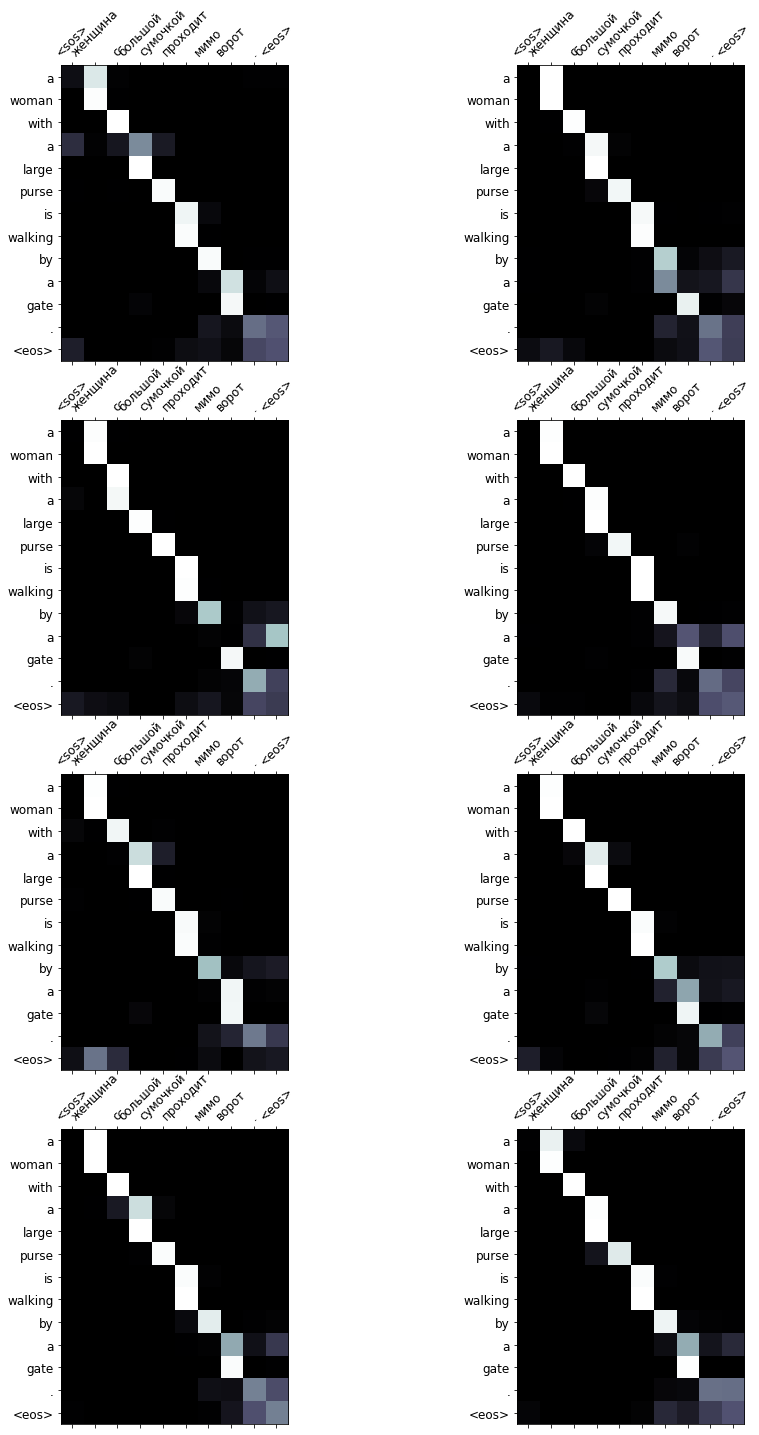

In [52]:
display_attention(src, translation, attention)

Далее возьмем пример, на котором модель не была обучена, из валидационного набора.

In [53]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['коричневая', 'собака', 'бегает', 'за', 'чёрной', 'собакой', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


Модель переводит, заменяя *after * на *behind*, что по смыслу не совсем верно. Но русский язык многозначен, поэтому может быть воспринято и так.

In [54]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'behind', 'a', 'black', 'dog', '.', '<eos>']


Ситуация аналогична

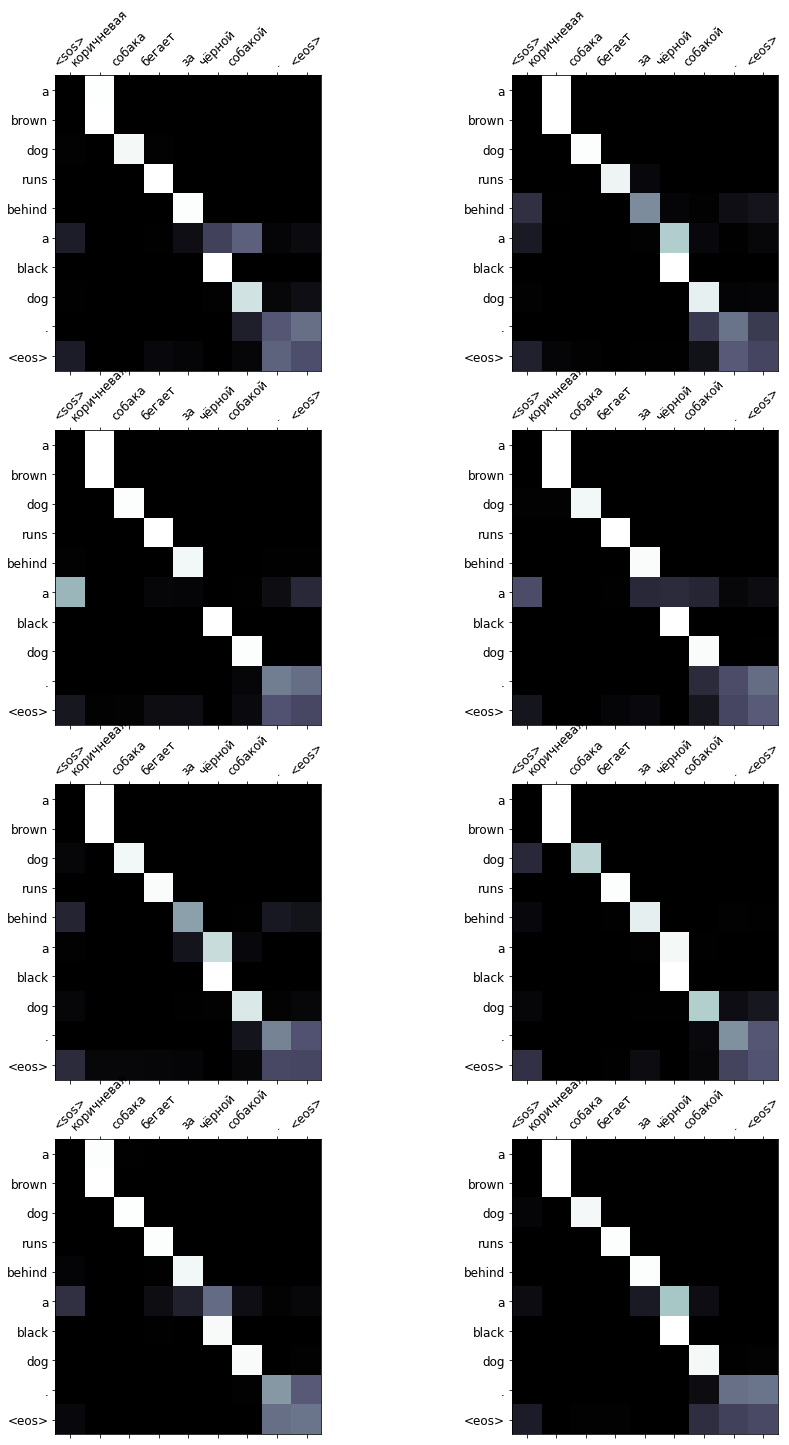

In [55]:
display_attention(src, translation, attention)

Наконец, рассмотрим пример из тестовой выборки

In [56]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['мать', 'и', 'ее', 'молодая', 'песня', 'наслаждаются', 'прекрасным', 'днем', 'снаружи', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


Тут скорее всего была ошибка в разметке. Вместо song должно было son. И модель устойчива к данной опечатке!

In [57]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'female', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


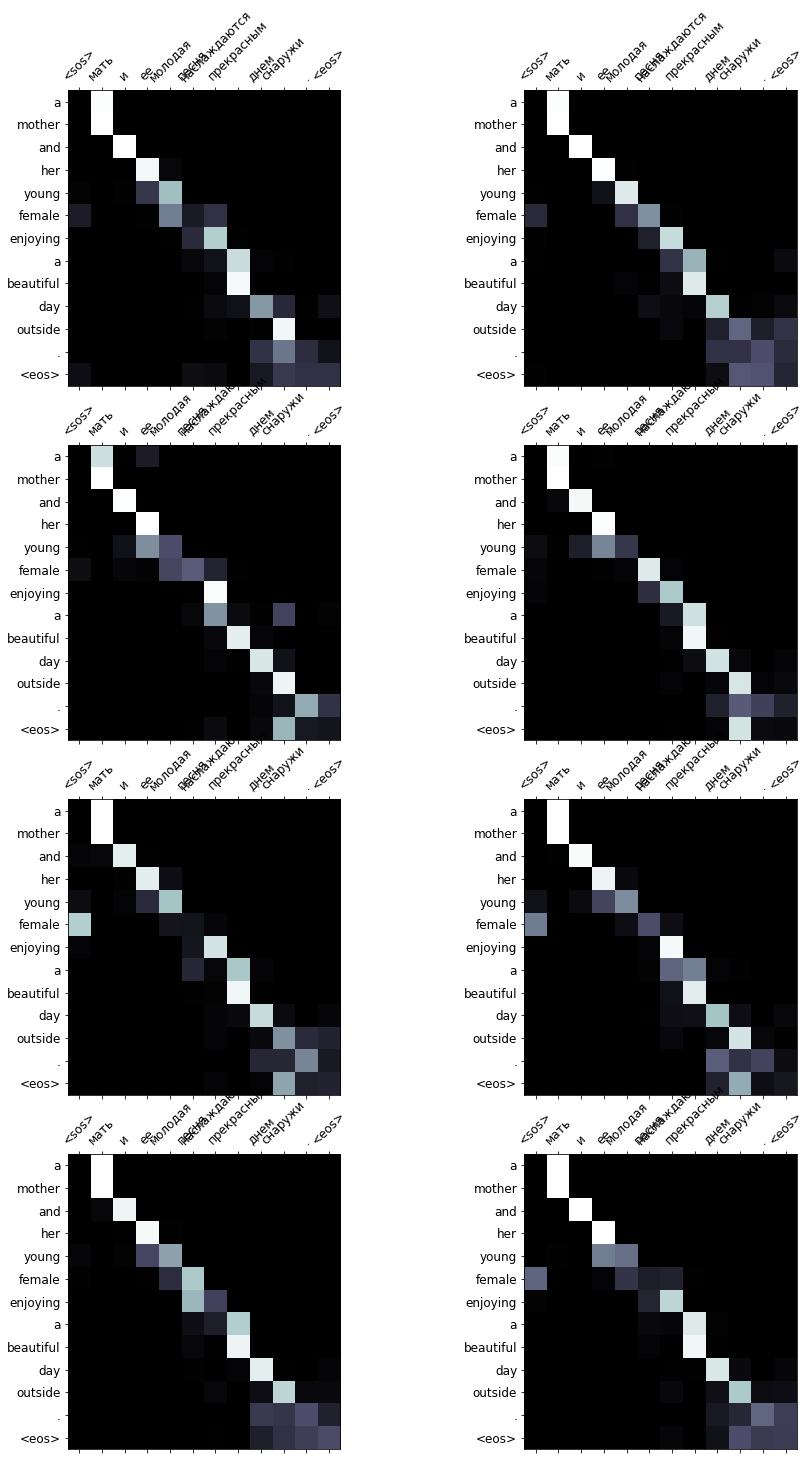

In [58]:
display_attention(src, translation, attention)

## BLEU

Рассчитываем оценку BLEU для трансформера (чем больше, тем лучше).

In [59]:
from torchtext.data.metrics import bleu_score
from tqdm.auto import tqdm

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    pbar = tqdm(total=len(data))
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        pbar.update(1)
        
    return bleu_score(pred_trgs, trgs)

Мы получаем оценку BLEU в 42 балла, что превышает ~ 40 баллов сверточной модели. Все это при меньшем количестве параметров и более быстром времени обучения!

In [60]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU score = 42.48


## Приложение

Выше приведённая функция `calculate_bleu` не оптимизирована. Ниже представлена намного более быстрая, векторизованная версия. Автор реализации [@azadyasar](https://github.com/azadyasar).

In [61]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [62]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)